In [7]:
import dataloaders.audio_dataset as dataset
import models.inversion_v3 as inversion_model
from abstract_model import AbstractModel

import os
import shutil

import torch
import torchaudio
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torchaudio.functional as F

from sklearn.metrics import confusion_matrix

from pytorch_lightning.core.saving import load_hparams_from_yaml

from tensorboard.backend.event_processing import event_accumulator
import numpy as np

from torch.utils.data import DataLoader

import librosa
import librosa.display

import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
n_dft = 2048
n_mels = 128
n_hop = 242
asr = 48000

In [9]:
def _load_run(path):
    event_acc = event_accumulator.EventAccumulator(path)
    event_acc.Reload()
    data = {}

    for tag in sorted(event_acc.Tags()["scalars"]):
        x, y = [], []

        for scalar_event in event_acc.Scalars(tag):
            x.append(scalar_event.step)
            y.append(scalar_event.value)

        data[tag] = (np.asarray(x), np.asarray(y))
    return data

In [11]:
# TEST - SPECIFIC VERSION - MSE loss and amplitude prediction

algo = "inversion_v3"
data_path = "/scratch/prs392/incubator/data/OpenMic/"
checkpoint_path = f"/scratch/prs392/incubator/checkpoints/openl3_openmic/{algo}/"
# experiment_name = "train_1000_audio_with_specific_hparams_with_emb_means_and_stds"
experiment_name = "overfitting_1_frame_specific_hparams"

AudioDatasetWithAmp = dataset.AudioDataset
InversionV3 = inversion_model.InversionV3

data_paths = {}
data_paths['train'] = os.path.join(data_path, 'train')
data_paths['val'] = os.path.join(data_path, 'val')
data_paths['test'] = os.path.join(data_path, 'test')

d = os.path.join(checkpoint_path, experiment_name)
versions = [o for o in os.listdir(d) if os.path.isdir(os.path.join(d,o))]

versions = sorted(versions)

for version in versions:
    if version == 'version_0':
        hparam_path = os.path.join(checkpoint_path, experiment_name, version, 'hparams.yaml')
#         hparams_new = load_hparams_from_yaml(hparam_path)


hparams_new = {
    'batch_size': 64,
    'lr': 0.0004136762567284789,
    'lr_type': 'adam',
    'scheduler_epoch': 1,
    'scheduler_step_size': 0.9465236907824874
}

version = 'version_0'

checkpoint_path = os.path.join(checkpoint_path, experiment_name, version, 'checkpoints')
epoch_file = [o for o in os.listdir(checkpoint_path) if os.path.isfile(os.path.join(checkpoint_path,o))][1]

PATH = os.path.join(checkpoint_path, f'last.ckpt') 

print(hparams_new)
print(epoch_file)

model = AbstractModel.load_from_checkpoint(PATH, hparams=hparams_new, 
                                            data_paths = data_paths, 
                                            dataset_model = AudioDatasetWithAmp,
                                            model = InversionV3(), 
                                            criterion = nn.MSELoss())

model = model.eval()

train_dataset = AudioDatasetWithAmp(
    root_dir=data_paths['train'], 
    num_audios = 10, 
    return_amp = True
)
# train_dataset = AudioDatasetWithAmp(root_dir=data_paths['test'], num_audios = 1000, return_amp = True)
# train_loader = DataLoader(train_dataset, batch_size=hparams_new['batch_size'], shuffle=False, num_workers=4, pin_memory=True)




{'batch_size': 64, 'lr': 0.0004136762567284789, 'lr_type': 'adam', 'scheduler_epoch': 1, 'scheduler_step_size': 0.9465236907824874}
epoch=50.ckpt


In [12]:
import torchaudio.functional as F

file_name = '011394_130560.npy'
embeddings_dir = os.path.join(data_paths['train'], 'embeddings_6144')
spectrograms_dir = os.path.join(data_paths['train'], 'spectrograms')
emb_path = os.path.join(embeddings_dir, file_name)        
spec_path = os.path.join(spectrograms_dir, file_name)

frame_idx = 0

with open(emb_path, 'rb') as f:
    emb = np.load(f)
with open(spec_path, 'rb') as f:
    spec = np.load(f)

emb_tensor = torch.from_numpy(emb[frame_idx])
spec_tensor = torch.from_numpy(spec[frame_idx]).permute(2, 0, 1)

spec_tensor_amp = F.DB_to_amplitude(x = spec_tensor, ref = 1, power = 0.5)

print(emb_tensor, spec_tensor_amp, file_name, torch.tensor(frame_idx))

tensor([ 2.1573, -0.0137,  1.6963,  ...,  0.6562,  0.8160,  2.4286]) tensor([[[3.7599e-02, 8.2684e-02, 9.8128e-02,  ..., 1.7105e-01,
          2.1871e-01, 2.3669e-01],
         [5.0485e-02, 1.0322e-01, 1.3179e-01,  ..., 1.8500e-01,
          2.2910e-01, 2.4625e-01],
         [5.7764e-02, 1.2228e-01, 1.7592e-01,  ..., 1.9574e-01,
          2.5546e-01, 2.7609e-01],
         ...,
         [1.0000e-04, 1.0000e-04, 1.0000e-04,  ..., 3.0924e-02,
          4.0509e-02, 4.4576e-02],
         [1.0000e-04, 1.0000e-04, 1.0000e-04,  ..., 3.0854e-02,
          4.0418e-02, 4.4476e-02],
         [1.0000e-04, 1.0000e-04, 1.0000e-04,  ..., 3.0811e-02,
          4.0361e-02, 4.4413e-02]]]) 011394_130560.npy tensor(0)


/ext3/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/ext3/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/ext3/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Using a target size (torch.Size([1, 128, 199])) that is different to the input size (torch.Size([128, 199])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  import sys


torch.Size([1, 128, 199]) torch.Size([128, 199])
tensor(0.0089, grad_fn=<MseLossBackward>)


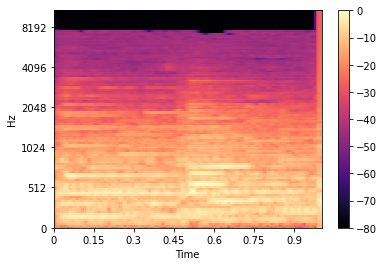

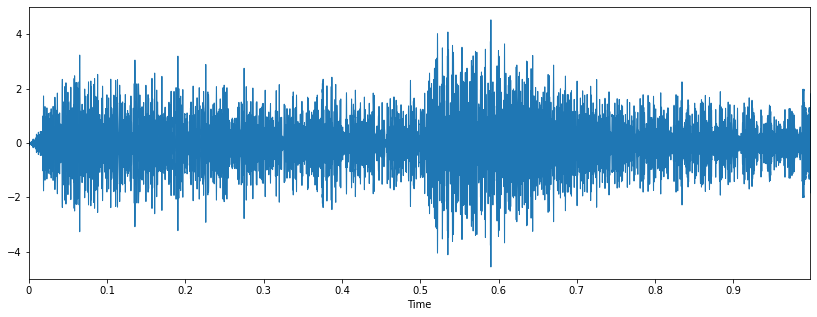

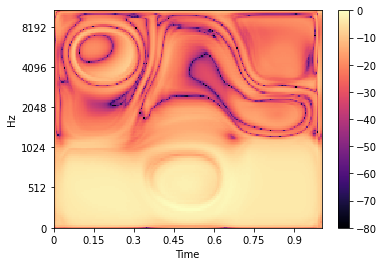

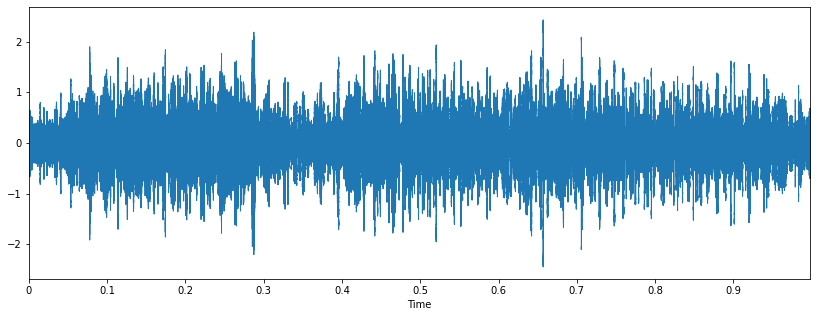

In [13]:

emb, spec, j = emb_tensor, spec_tensor_amp, frame_idx

pred = model(emb)

print(torch.tensor(spec).shape, pred[0, 0, :, :].shape)

print(torch.nn.functional.mse_loss(pred[0, 0, :, :], torch.tensor(spec)))
        
plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(np.abs(spec[:,:,:].detach().numpy())[0,:,:], ref=np.max), 
                         y_axis='mel', 
                         x_axis='time',
                         sr=asr,
                         hop_length=n_hop)
plt.colorbar()


import torchaudio.functional as F

n_dft = 2048
n_mels = 128
n_hop = 242
asr = 48000

# spec_tensor_amp = F.DB_to_amplitude(x = spec[0,:,:].detach(), ref = 1, power = 1)
spec_tensor_amp = np.abs(spec[:,:,:].detach().numpy())[0,:,:]


y = librosa.feature.inverse.mel_to_audio(spec_tensor_amp, sr=asr, n_fft=n_dft, hop_length=n_hop, center=True, n_iter=100,  power=0.5)
# y *= 32767 / max (0.01, np.max(np.abs(y)))
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=48000)
import IPython.display as ipd

import IPython

IPython.display.display(ipd.Audio(y, rate=48000))

plt.subplots()
pred_spec_tensor_amp = np.abs(pred[0].detach().numpy())[0,:,:]

librosa.display.specshow(
    librosa.amplitude_to_db(pred_spec_tensor_amp, ref=np.max), 
    y_axis='mel', 
    x_axis='time',
    sr=asr,
    hop_length=n_hop
)
plt.colorbar()


import torchaudio.functional as F

n_dft = 2048
n_mels = 128
n_hop = 242
asr = 48000

# spec_tensor_amp = F.DB_to_amplitude(x = spec[0,:,:].detach(), ref = 1, power = 1)
spec_tensor_amp = np.abs(pred[0].detach().numpy())[0,:,:]


y = librosa.feature.inverse.mel_to_audio(spec_tensor_amp, sr=asr, n_fft=n_dft, hop_length=n_hop, center=True, n_iter=100,  power=0.5)
# y *= 32767 / max (0.01, np.max(np.abs(y)))
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=48000)
import IPython.display as ipd

IPython.display.display(ipd.Audio(y, rate=48000))


In [20]:
for i in range(len(train_dataset)):
    emb, spec, j = train_dataset[i]

    if i == 30:
        pred = model(emb)
        break
        
plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(np.abs(spec[:,:,:].detach().numpy())[0,:,:], ref=np.max), 
                         y_axis='mel', 
                         x_axis='time',
                         sr=asr,
                         hop_length=n_hop)
plt.colorbar()


import torchaudio.functional as F

n_dft = 2048
n_mels = 128
n_hop = 242
asr = 48000

# spec_tensor_amp = F.DB_to_amplitude(x = spec[0,:,:].detach(), ref = 1, power = 1)
spec_tensor_amp = np.abs(spec[:,:,:].detach().numpy())[0,:,:]


y = librosa.feature.inverse.mel_to_audio(spec_tensor_amp, sr=asr, n_fft=n_dft, hop_length=n_hop, center=True, n_iter=32,  power=0.5)
# y *= 32767 / max (0.01, np.max(np.abs(y)))
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=48000)
import IPython.display as ipd

import IPython

IPython.display.display(ipd.Audio(y, rate=48000))

plt.subplots()
pred_spec_tensor_amp = np.abs(pred[0].detach().numpy())[0,:,:]

librosa.display.specshow(
    librosa.amplitude_to_db(pred_spec_tensor_amp, ref=np.max), 
    y_axis='mel', 
    x_axis='time',
    sr=asr,
    hop_length=n_hop
)
plt.colorbar()


import torchaudio.functional as F

n_dft = 2048
n_mels = 128
n_hop = 242
asr = 48000

# spec_tensor_amp = F.DB_to_amplitude(x = spec[0,:,:].detach(), ref = 1, power = 1)
spec_tensor_amp = np.abs(pred[0].detach().numpy())[0,:,:]


y = librosa.feature.inverse.mel_to_audio(spec_tensor_amp, sr=asr, n_fft=n_dft, hop_length=n_hop, center=True, n_iter=32,  power=0.5)
# y *= 32767 / max (0.01, np.max(np.abs(y)))
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=48000)
import IPython.display as ipd

IPython.display.display(ipd.Audio(y, rate=48000))


ValueError: too many values to unpack (expected 3)